# 10. Spatiocyte Simulations at Single-Molecule Resolution

We showed an example of E-Cell4 spatial representation.  
Next let's simulate the models with more detailed spatial representation called "single molecule resolution".

In [1]:
%matplotlib inline
from ecell4 import *

## 10.1. Spatiocyte Lattice-based Method

In spatical Gillespie method, we divided the `Space` into smaller `Space`, then we diffuse the molecules in the subvolumes.
However, we treated the molecules in each subvolume just as the number of the molecules, and the location of the molecules are NOT determinated.

In other words, the spatical resolution of spatical Gillespie method is equal to the side of a subvolume $l$.
To improve this resolution, we need to make the size of $l$ small. But in this method the $l$ must be larger than the (at least) 10 times the diameter of molecule $R$.

How can we improve the spatical resolution to the size of the molecule?
The answer is the simulation with single-molecule resolution.
This method simulate the molecule not with the number of the molecules, but with the spatical reaction diffusion of each molecule.

E-Cell4 has multiple single-molecule resolution method, here we explain about Spatiocyte lattice-based method.
Spatiocyte treats each molecule as hard spheres, and diffuses the molecules on hexagonal close-packed lattice.

Spatiocyte has an ID for each molecule and the position of the molecule with single-molecule resolution.
For the higher spatial resolution, Spatiocyte has 100 times smaller time-step than spatical Gillespie, because the time scale of diffusion increases with the square of the distance.

Next, let's try the Spatiocyte method.

In [2]:
with species_attributes():
    A | B | C | {'D': '1'}

with reaction_rules():
    A + B == C | (0.01, 0.3)

m = get_model()

w = spatiocyte.SpatiocyteWorld(Real3(1, 1, 1), 0.005)  # The second argument is 'voxel_radius'.
w.bind_to(m)
w.add_molecules(Species('C'), 60)

sim = spatiocyte.SpatiocyteSimulator(w)
obs = FixedIntervalNumberObserver(0.1, ('A', 'B', 'C'))
sim.run(10, obs)

There is a distinct difference in the second argument for `SpatiocyteWorld`. This is called `voxel radius`.
Spatiocyte defines the locations of the molecules with dividing the space with molecule size, and call the minimum unit for this space as `Voxel`.

In most cases the size of the molecule would be good for `voxel radius`.
In this example, we set 5 $\mathrm{nm}$ as the radius of the molecule in the space with the side 1 $\mathrm{\mu m}$ .
It takes more time to simulate, but the result is same with ODE or Gillespie.

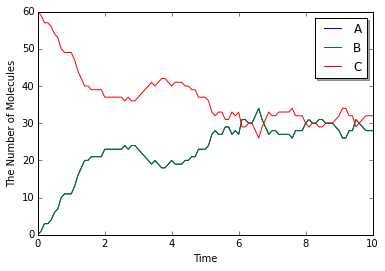

In [3]:
viz.plot_number_observer(obs)

## 10.2. The Diffusion Movement of Single Molecule

Next let's simulate single molecule diffusion to check the resolution.

In [4]:
with species_attributes():
    A | {'D': '1'}

m = get_model()

w = spatiocyte.SpatiocyteWorld(Real3(1, 1, 1), 0.005)
w.bind_to(m)

(pid, p), suc = w.new_particle(Species('A'), Real3(0.5, 0.5, 0.5))

`new_particle` method tries to place a particle to a coordinate in `SpatiocyteWorld`. It returns the particle's `ParticleID` (`pid`), the `Particle` object (`p`), and the boolean value (`suc`). If `new_particle` succeeds in putting the particle,` suc` will be True.
If a particle is already placed in the coordinate, you can NOT place a particle over it and `suc` will be `False` and fail.

`p` contains the particle position, species type, radius, and diffusion coefficient.
You can inspect the `p` with the particle's ID, `pid`.

Let's check `p` first.

In [5]:
pid, p = w.get_particle(pid)
print(p.species().serial())  # must print: A
print(p.radius(), p.D())  # must print: (0.005, 1.0)
print(tuple(p.position()))  # must print: (0.49806291436591293, 0.49652123150307814, 0.5)

A
(0.005, 1.0)
(0.49806291436591293, 0.49652123150307814, 0.5)


`get_particle` method receives a particle ID and returns the ID and particle (of cource the ID are same with the given one).
You can inspect the coordinate of the particle as `Real3` with `position()` method.
It is hard to directly read the coordinate, here we printed it after converting to tuple.
As you can see the tuple coodinate is slightly different from the original position given as a `Real3`. This is because Spatiocyte can place the molecule only on the lattice.
`SpatiocyteWorld` places the molecule a center position of the nearest lattice for the argument `Real3`.

You can visualize the coordinate of the molecule with `viz.plot_world` method, and check the molecule in the center of the World.

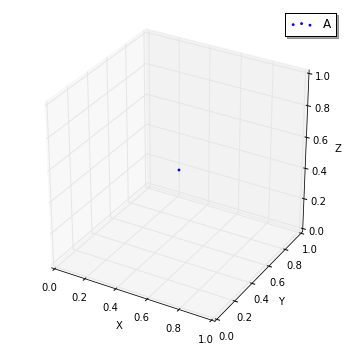

In [6]:
viz.plot_world(w, interactive=False)
# viz.plot_world(w)

And you can use `FixedIntervalTrajectoryObserver` to track the trajectory of molecular diffusion process.

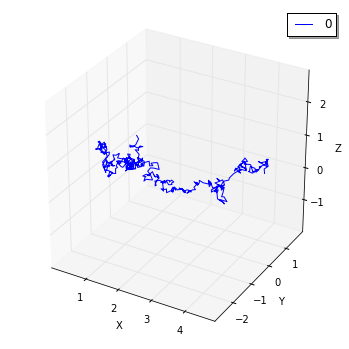

In [7]:
sim = spatiocyte.SpatiocyteSimulator(w)
obs = FixedIntervalTrajectoryObserver(0.002, (pid,))
sim.run(1, obs)
viz.plot_trajectory(obs, interactive=False)
# viz.plot_trajectory(obs)

Here we visualized the trajectory with `viz.plot_trajectory` method, you can also obtain it as `Real3` list with `data()` method.

In [8]:
print(len(obs.data()))  # => 1
print(len(obs.data()[0]))  # => 501

1
501


`data()` method returns nested list.
First index means the index of the particle.
Second index means the index of the `Real3`.
In this case we threw just one particle, so the first result is `1`, and next `501` means time-series coordinate of the only one particle (initial coordinate and the coordinates in 1/0.002 = 500 time points).

Also you can obtain the particles in bulk with `list_particles_exact` method and a `Species`.

In [9]:
w.add_molecules(Species('A'), 5)

particles = w.list_particles_exact(Species('A'))
for pid, p in particles:
    print(p.species().serial(), tuple(p.position()))

(u'A', (0.7103520254071217, 0.8256108849411649, 0.88))
(u'A', (0.5062278801751902, 0.034641016151377546, 0.77))
(u'A', (0.4082482904638631, 0.7188010851410841, 0.985))
(u'A', (0.30210373494325865, 0.30599564267050167, 0.68))
(u'A', (0.28577380332470415, 0.26269437248127975, 1.0050000000000001))
(u'A', (0.563382640840131, 0.0202072594216369, 0.545))


Please remember `list_particles_exact` method, this method can be used for other World as well as `add_molecules` method.

On a different note, in Spatiocyte proper method to inspect the single molecule is `list_voxels_exact`, and the coordinate is described with index of voxel (not `Real3`).

## 10.3 The Diffusion Coefficient and the Second-order Reaction

The models we have addressed contains a second-order reaction.
Let's look at the relationship between this second-order reaction and the diffusion coefficient in Spatiocyte.

In [10]:
with species_attributes():
    A | B | C | {'D': '1'}

with reaction_rules():
    A + B > C | 1.0

m = get_model()

In [11]:
w = spatiocyte.SpatiocyteWorld(Real3(2, 1, 1), 0.005)
w.bind_to(m)
w.add_molecules(Species('A'), 120)
w.add_molecules(Species('B'), 120)

obs = FixedIntervalNumberObserver(0.005, ('A', 'B', 'C'))
sim = spatiocyte.SpatiocyteSimulator(w)
sim.run(1.0, obs)

In [12]:
odew = ode.ODEWorld(Real3(2, 1, 1))
# odew.bind_to(m)
odew.add_molecules(Species('A'), 120)
odew.add_molecules(Species('B'), 120)

odeobs = FixedIntervalNumberObserver(0.005, ('A', 'B', 'C'))
odesim = ode.ODESimulator(m, odew)
odesim.run(1.0, odeobs)

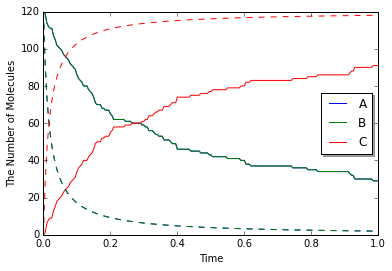

In [13]:
viz.plot_number_observer(obs, "-", odeobs, "--")

Although we used faster kinetic constant than before, the result is same.
But by contrast with ODE simulation, you can find the difference between them (solid line is `spatiocyte`, dash line is `ode`).
Is this fault of Spatiocyte? (No)
Actually Spatiocyte reaction rate couldn't be faster, while ODE reaction rate can be faster infinitely.

This is caused by the difference between the definition of reaction rate constant in ODE solver and single molecule simulation method.
The former is called "macroscopic" or "effective" reaction rate constant, the latter is called "microscopic" or "intrinsic" reaction rate constant.

The "macroscopic"  rate represents the reaction rate in mixed molecular state, meanwhile "microscopic" rate represents the reactivity in molecule collision.
So in "microscopic" perspective, the first thing molecules need to react is collision.
In Spatiocyte, however, you make this "microscopic" rate faster, you can NOT make the actual reaction rate faster than collision rate.
This is called "diffusion-limited" condition.
This is similar to what the molecules coordinated disproportionately need time to react.

It is known that there is a relationship between this macroscopic rate constant $k_\mathrm{on}$ and microscopic rate constant $k_a$ in 3D space.

$\frac{1}{k_\mathrm{on}}=\frac{1}{k_a}+\frac{1}{4\pi RD_\mathrm{tot}},$

where $R$ is the sum of two molecule's radius in collision, $D_\mathrm{tot}$ is the sum of diffusion coefficients.

In the case of the above Jupyter Notebook cell, $k_D=4\pi RD_\mathrm{tot}$ is almost 0.25 and "microscopic" rate constant is 1.0.
So the "macroscopic" rate constant is almost 0.2.
(However unless you specify the configuration for Spatiocyte, the second order reaction rate must be slower than $3\sqrt{2} RD$, and the dissociation constant $k_D$ is also $3\sqrt{2} RD$.)
The single molecule simulation method can separate molecular "diffusion" and "reaction" in accurate manner contrary to ODE or Gillespie method supposed well mixed system (that is diffusion coefficient is infinite).
However if the microscopic rate constant $k_D$ is small enough, the macroscopic rate constant is almost equal to microscopic one (reaction late-limit).

## 10.4. The Structure in the Spatiocyte Method

Next we explain a way to create a structure like cell membrane.
Although The structure feature in E-Cell4 is still in development, Spatiocyte supports the structure on some level.
Let's look a sphere structure as an example.

To restrict the molecular diffusion inside of the sphere, first we create it.

In [14]:
with species_attributes():
    A | {'D': '1', 'location': 'C'}

m = get_model()

In [15]:
w = spatiocyte.SpatiocyteWorld(Real3(1, 1, 1), 0.005)
w.bind_to(m)
sph = Sphere(Real3(0.5, 0.5, 0.5), 0.45)
print(w.add_structure(Species('C'), sph))  # will print 539805

539805


Visualize the state of the `World`.

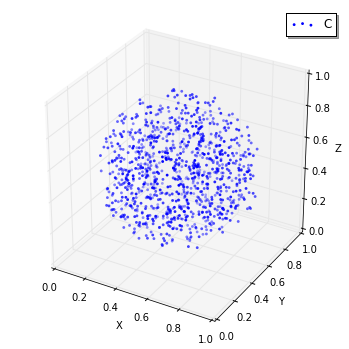

In [16]:
viz.plot_world(w, interactive=False)
# viz.plot_world(w)

The `Sphere` class first argument is the center of the sphere, and second argument is the radius.
Then we created a `Species` named `C` and added it inside the `Sphere`.
The structure in the Spatiocyte method is described by filling the space with the `Voxel`.
In the example above, the `Voxel`s in the sphere are occupied with `Species` named `C`.

You can see those distribution with `viz.plot_world` as above.
(However, the number of the species is too large to visualize all. So we plot only a part of it, but actually the sphere is fully occupied with the `Species`.)

Next we create Species moving inside this sphere. To that end we give `location` attribute to the `Species`. After that, you just throw-in molecules to the `World` with `add_molecules` function.

In [17]:
w.add_molecules(Species('A'), 120)

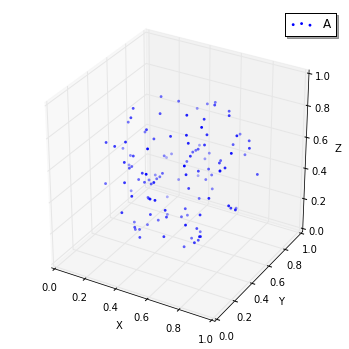

In [18]:
viz.plot_world(w, species_list=('A',), interactive=False)  # visualize A-molecules only
# viz.plot_world(w, species_list=('A',))  # visualize A-molecules only

Now we restricted the trajectories of `Species` `A` on the structure of Species `C`, and `add_molecules` works like that. As a note, you need to create the structure before `add_molecule`.

We can use `FixedIntervalTrajectoryObserver` to check the restriction of the diffusion area.

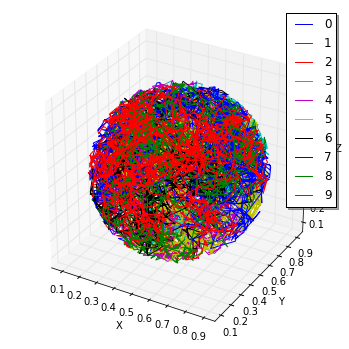

In [19]:
pid_list = [pid for pid, p in w.list_particles(Species('A'))[: 10]]
obs = FixedIntervalTrajectoryObserver(1e-3, pid_list)
sim = spatiocyte.SpatiocyteSimulator(w)
sim.run(1, obs)
viz.plot_trajectory(obs, interactive=False)
# viz.plot_trajectory(obs)

`pid_list` is a list of the first 10 `ParticleID`s of `A` molecules.
The trajectories are colored by this 10 species.
Certainly the trajectories are restricted in the sphere.

## 10.5 The structure and the reaction

At the end, we explain about molecular translocation among the structures.

A `Species` without `location` attribute is not an member of any structures.
In the example above, if you do NOT write `location` attribute with Species `A`, `A` is placed outside of the sphere.

Next let's create a planar surface structure.
To create a surface, we need to use three Real3, those are original point (`origin`) and two axis vector (`unit0`, `unit1`): `ps = PlanarSurface(origin, unit0, unit1)`.

Suppose Species `A` on the surface, `ps`, and a normal Species `B`.

In [20]:
with species_attributes():
    A | {'D': '0.1', 'location': 'M'}
    B | {'D': '1'}

m  = get_model()

w = spatiocyte.SpatiocyteWorld(Real3(1, 1, 1))
w.bind_to(m)

origin = Real3(0, 0, 0.5)
unit0 = Real3(1, 0, 0)
unit1 = Real3(0, 1, 0)
w.add_structure(
    Species('M'), PlanarSurface(origin, unit0, unit1))  # Create a structure first

w.add_molecules(Species('B'), 480)  # Throw-in B-molecules

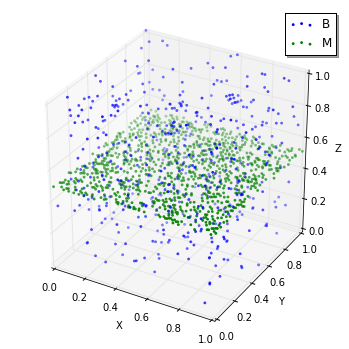

In [21]:
viz.plot_world(w, species_list=('B', 'M'), interactive=False)
# viz.plot_world(w, species_list=('B', 'M'))

It might be hard to see them, but actually the `Species` `B` are placed only not on a surface.
Then how can we make absorbed this `Species` `B` to a surface `M` and synthesize a `Species` `A`?

In [22]:
with species_attributes():
    A | {'D': '0.1', 'location': 'M'}
    B | {'D': '1'}

with reaction_rules():
    B + M == A | (1.0, 1.5)

m = get_model()

This means that a `Species` `B` becomes `A` when `B` collides with a structure `M`.
On the other hand, a species `A` dissociates from the structure, and becomes `M` and `B` on as the reverse reaction direction.

Now you can simulate this model with a structure.

In [23]:
w.bind_to(m)

sim = spatiocyte.SpatiocyteSimulator(w)
obs = NumberObserver(('A', 'B'))
sim.run(2, obs)

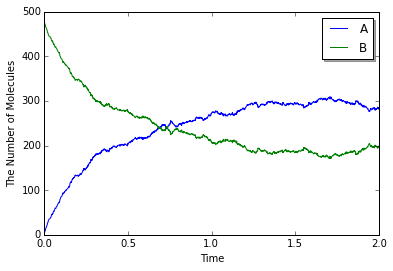

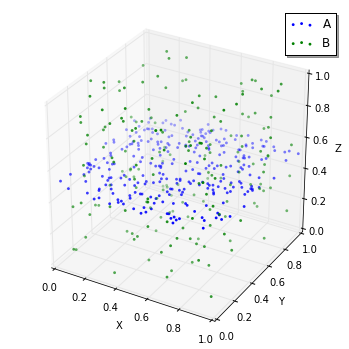

In [24]:
viz.plot_number_observer(obs)
viz.plot_world(w, species_list=('A', 'B'), interactive=False)
# viz.plot_world(w, species_list=('A', 'B'))

In the dissociation from a structure, you can skip to write the structure. Thus, `A > B` just means the same as `A > B + M` in the above.
But in the binding, you can **NOT**.
Because it is impossible to create `A` from `B` with no `M` around there.
By contrast the species `A` wherever on the sphere `M` can create the species `B`.
The first order reaction occurs in either presence or absence of the structure.
But, in the case of the binding, the second order reaction turns into the first order reaction and the meaning of rate constant also changes if you ignore `M` in the left-hand side.